In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


train_df = pd.read_csv("data/train_ship_segmentations_v2.csv")
train_images_folder = "data/train_v2/"

## Utils

In [40]:
def get_img(img_folder, img_filename):
    img_path = os.path.join(img_folder, img_filename)
    img = cv2.imread(img_path)
    assert img is not None, f"Image {img_filename} doesn't found"
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def get_img_mask(data, img_filename):
    img_masks = data[data['ImageId'] == img_filename]['EncodedPixels'].values[0].split(',')
    mask = np.zeros((768, 768))
    for m in img_masks:
        mask += rle_decode(m)
    return mask


def rle_decode(mask_rle, shape=(768, 768)):
    """
    Decode a Run-Length Encoded (RLE) binary mask into a 2D numpy array.

    Parameters:
    - mask_rle (str): The RLE-encoded string representing the binary mask.
    - shape (tuple, optional): The shape of the target 2D array. Default is (768, 768).

    Returns:
    - numpy.ndarray: A 2D binary array representing the decoded mask.
    """

    if mask_rle == ['nan']:
        return np.zeros(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(shape).T # Needed to align to RLE direction

def display_images(data, img_folder, model, seed=1):
    """
    Display a set of images from the dataset, showing both images with and without ships,
    along with their corresponding masks and annotations.
    Parameters:
    data (DataFrame): A pandas DataFrame containing image metadata including 'ImageId' and 'ShipsAmount'.
    img_folder (str): The directory path where the images are stored.
    seed (int): The random seed for reproducibility. Default is 1.
    """
    num_images = 5
    images_with_ships = data.query('ShipsAmount > 0')
    with_ships_sample = images_with_ships.sample(n=num_images, random_state=seed)['ImageId'].to_list()
    
    num_cols = 5
    num_rows = 3
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 12))
    fig.suptitle('Ship Detection Dataset Visualization', fontsize=16)
    
    row_labels = ['Original Images', 'Original Masks', 'Model Predictions']
    for i, label in enumerate(row_labels):
        fig.text(0.02, 0.75 - i*0.25, label, va='center', rotation='vertical', fontsize=12)
    
    for i in range(num_images):
        img_with_ships = get_img(img_folder, with_ships_sample[i])
        orig_mask = get_img_mask(data, with_ships_sample[i])
        # Model predicted mask
        processed_img = cv2.resize(img_with_ships, (256,256))
        processed_img = processed_img / 255
        processed_img = np.expand_dims(processed_img, axis=0)
        model_mask = model.predict(processed_img, verbose=0)
        model_mask = np.squeeze((model_mask > 0.2).astype(int), axis=0)
        
        ships_num = data[data['ImageId'] == with_ships_sample[i]].values[0][2]
        img_label = f'Ships amount: {ships_num}'
        # Додаємо до зображення напис про кількість кораблів
        img_with_ships = cv2.putText(img_with_ships, img_label, (5, 750), cv2.FONT_HERSHEY_PLAIN, 5, (255, 255, 255), thickness=2) 
        # Додаємо до зображення напис про ід зображення
        img_with_ships = cv2.putText(img_with_ships, with_ships_sample[i], (5, 90), cv2.FONT_HERSHEY_PLAIN, 5, (255, 0, 0), thickness=5) 
                  
        axes[0, i].imshow(img_with_ships)
        axes[0, i].axis('off')
        axes[1, i].imshow(orig_mask)
        axes[1, i].axis('off')
        axes[2, i].imshow(model_mask)
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93, left=0.05)  # Збільшуємо відступ зліва для заголовків
    plt.show()

## Data Preprocessing

In [46]:
train_df['HasShip'] = train_df['EncodedPixels'].notna().apply(lambda x: 1 if x == True else 0)
train_df_grouped = train_df.groupby('ImageId').agg({'EncodedPixels': lambda x: ','.join(x.astype('str')), 
                                                 'HasShip': 'sum'}).reset_index()

train_df_grouped.rename(columns={'HasShip': 'ShipsAmount'}, inplace=True)
train_df_grouped.head()

model = load_model('unet_model2.h5')

## Model Predictions Vizualization

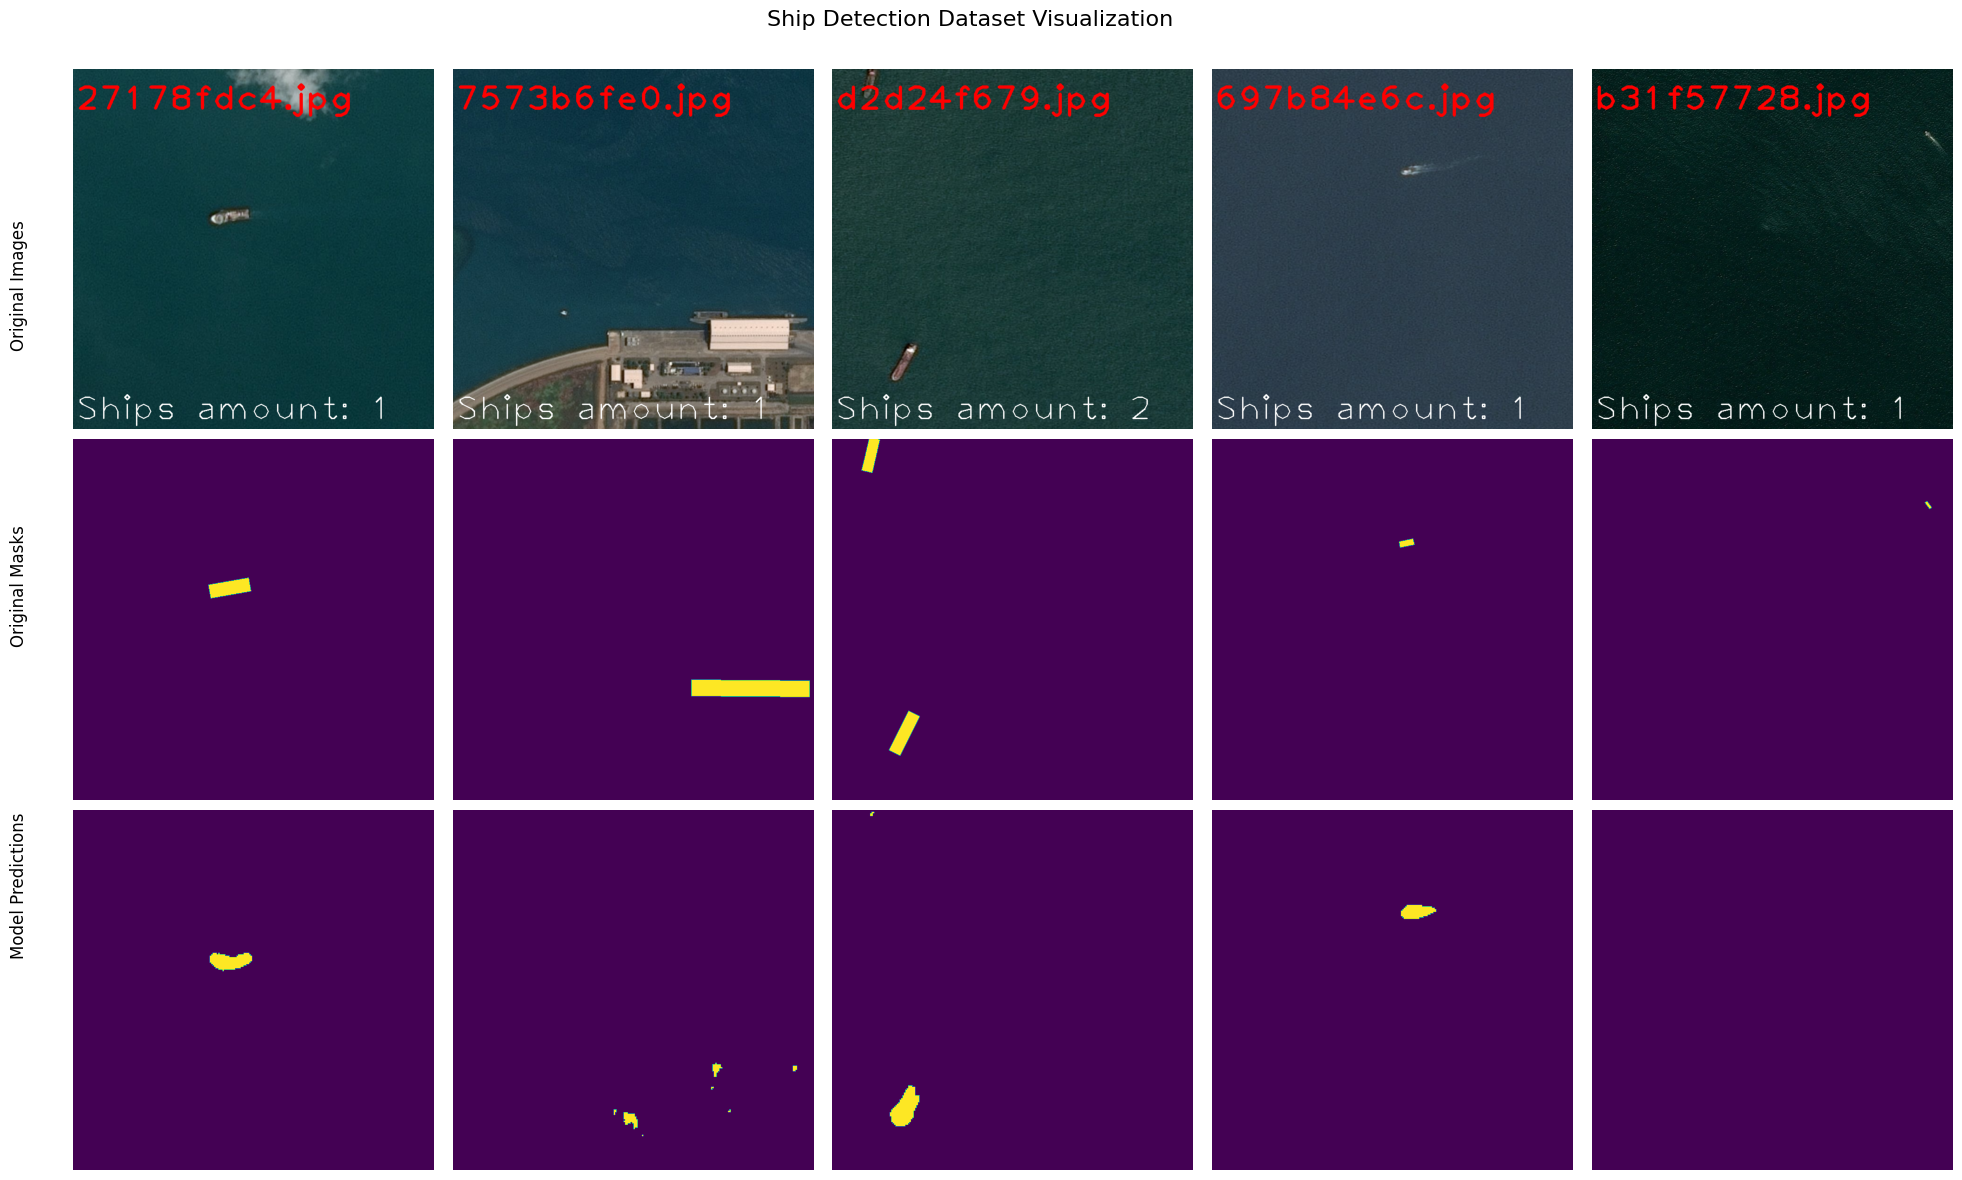

In [48]:
# Feel fry to change the "seed" to see different images
seed = 15
display_images(train_df_grouped, train_images_folder, model, seed)